# Binary Image Classification 

### Sofia Introzzi

## Import Libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
import os
import os.path
from pathlib import Path

In [3]:
import glob
import pathlib
import PIL
from PIL import Image

In [4]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import activations, layers, optimizers, losses
from tensorflow.keras.models import Sequential 
from tensorflow.io import read_file
from tensorflow.image import decode_image
from tensorflow.keras.utils import to_categorical

## Image Preprocessing

In [5]:
data_dir = pathlib.Path("data/")

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

24761


In [7]:
dog = list(data_dir.glob('Dogs/*'))
cat = list(data_dir.glob('Cats/*'))

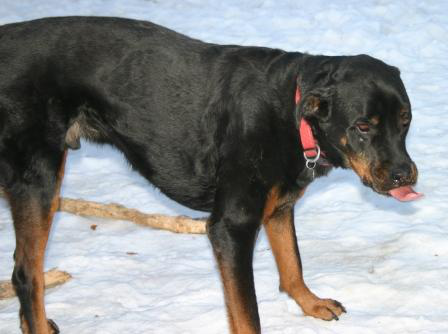

In [8]:
PIL.Image.open(str(dog[2]))

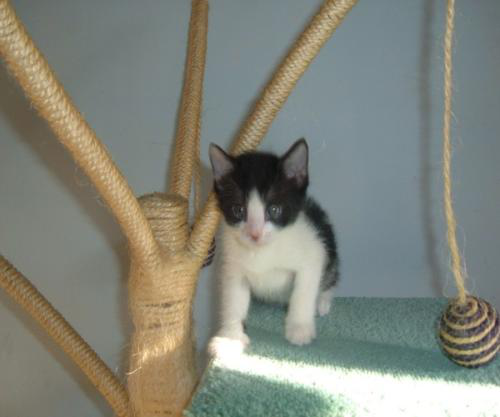

In [9]:
PIL.Image.open(str(cat[3]))

In [10]:
PIL.Image.open(str(dog[563])).size

(410, 500)

In [11]:
def find_corrupt_img(pet_dir):
    for image in pet_dir:
        try:
            img = PIL.Image.open(str(image))
            img_array = np.array(img)
            
            if img.mode != 'RGB' or img.layers != 3:
                Path(image).unlink()
        except:
            Path(image).unlink()

In [ ]:
find_corrupt_img(dog)

In [ ]:
find_corrupt_img(cat)

In [12]:
image_count = len(list(data_dir.glob("*/*.jpg"))) 
cats_count = len(list(data_dir.glob("Cats/*.jpg"))) 
dogs_count = len(list(data_dir.glob("Dogs/*.jpg"))) 

In [13]:
print(image_count)
print(cats_count)
print(dogs_count)

24761
12402
12359


### Image Load 

In [14]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [15]:
for f in list_ds.take(5):
    print(f.numpy())

b'data/Dogs/10641.jpg'
b'data/Cats/4585.jpg'
b'data/Dogs/8857.jpg'
b'data/Cats/3392.jpg'
b'data/Cats/10957.jpg'


In [16]:
# here I put .DB_Store but it can be LICENSE.txt too 
class_names = np.array(sorted([item.name for item in data_dir.glob('*')if item.name != ".DS_Store"]))
print(class_names)

['Cats' 'Dogs']


In [17]:
train_size = int(image_count * 0.7)
val_size = int(image_count * 0.15)
test_size = int(image_count * 0.15)

In [18]:
shuffled_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

train_ds = shuffled_ds.take(train_size) #
remaining_ds = shuffled_ds.skip(train_size)

val_ds = remaining_ds.take(val_size) #
remaining_ds = remaining_ds.skip(val_size)

test_ds = remaining_ds.take(test_size) #

In [19]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())
print(tf.data.experimental.cardinality(test_ds).numpy())

17332
3714
3714


In [20]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

In [21]:
AUTOTUNE = tf.data.AUTOTUNE
img_height, img_width = 104, 104
batch_size = 32

In [22]:
def decode_img(img):
    img = tf.io.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

In [23]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [24]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [25]:
for image, label in train_ds.take(3):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (104, 104, 3)
Label:  0
Image shape:  (104, 104, 3)
Label:  1
Image shape:  (104, 104, 3)
Label:  1


In [26]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

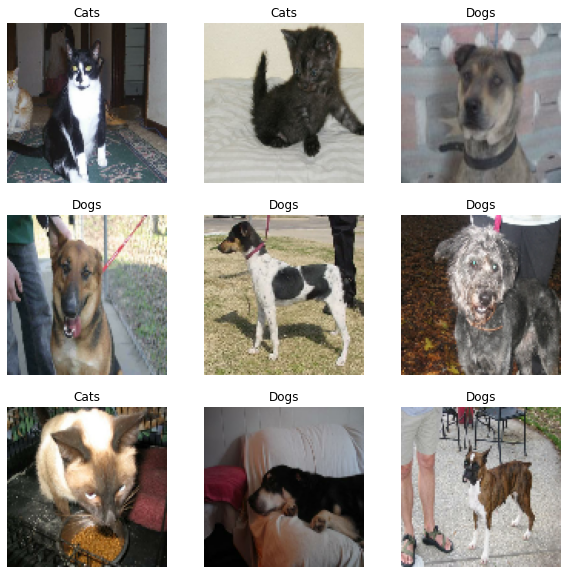

In [27]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

# Models

In [28]:
channels = 3
num_classes = len(class_names)

# Multilayer Perceptron Neural Network

## MLP - Model 1 

In [29]:
img_height = 104
img_width = 104
batch_size = 32
epochs = 10

In [30]:
model = tf.keras.Sequential([
    
    layers.Flatten(input_shape=(img_height, img_width, 3)),
    
    layers.Dense(80, activation= "relu"),
    layers.Dense(44, activation= "relu"),
    
    layers.Dense(num_classes, activation="softmax")
])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 32448)             0         
                                                                 
 dense (Dense)               (None, 80)                2595920   
                                                                 
 dense_1 (Dense)             (None, 44)                3564      
                                                                 
 dense_2 (Dense)             (None, 2)                 90        
                                                                 
Total params: 2,599,574
Trainable params: 2,599,574
Non-trainable params: 0
_________________________________________________________________


In [223]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
542/542 [==============================] - 41s 72ms/step - loss: 63.1709 - accuracy: 0.5338 - val_loss: 13.0277 - val_accuracy: 0.5191
Epoch 2/10
542/542 [==============================] - 55s 101ms/step - loss: 8.0179 - accuracy: 0.5495 - val_loss: 4.2082 - val_accuracy: 0.4992
Epoch 3/10
542/542 [==============================] - 48s 88ms/step - loss: 6.1567 - accuracy: 0.5554 - val_loss: 1.3704 - val_accuracy: 0.5407
Epoch 4/10
542/542 [==============================] - 43s 79ms/step - loss: 0.9261 - accuracy: 0.5721 - val_loss: 1.0876 - val_accuracy: 0.5116
Epoch 5/10
 52/542 [=>............................] - ETA: 40s - loss: 0.9411 - accuracy: 0.5577

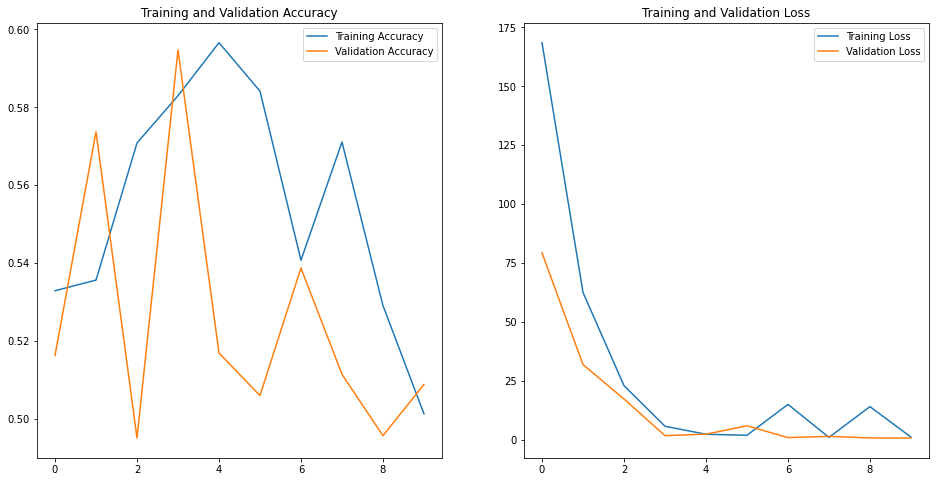

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## MLP - Model 2

In [226]:
img_height = 104
img_width = 104
batch_size = 32
epochs = 10

In [ ]:
model = tf.keras.Sequential([
    
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Flatten(input_shape=(img_height, img_width, 3)),
    
    layers.Dense(56, activation= "relu"),
    layers.Dense(32, activation= "relu"),
    
    layers.Dense(num_classes, activation="softmax")
])

In [222]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 104, 104, 3)       0         
                                                                 
 flatten_8 (Flatten)         (None, 32448)             0         
                                                                 
 dense_12 (Dense)            (None, 56)                1817144   
                                                                 
 dense_13 (Dense)            (None, 32)                1824      
                                                                 
 dense_14 (Dense)            (None, 2)                 66        
                                                                 
Total params: 1,819,034
Trainable params: 1,819,034
Non-trainable params: 0
_________________________________________________________________


In [229]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [224]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
542/542 [==============================] - 57s 102ms/step - loss: 0.9390 - accuracy: 0.5482 - val_loss: 0.6613 - val_accuracy: 0.6061
Epoch 2/10
542/542 [==============================] - 38s 69ms/step - loss: 0.6808 - accuracy: 0.5916 - val_loss: 0.6516 - val_accuracy: 0.6139
Epoch 3/10
542/542 [==============================] - 34s 63ms/step - loss: 0.6641 - accuracy: 0.6068 - val_loss: 0.7383 - val_accuracy: 0.5258
Epoch 4/10
542/542 [==============================] - 36s 66ms/step - loss: 0.6695 - accuracy: 0.5927 - val_loss: 0.6794 - val_accuracy: 0.5614
Epoch 5/10
542/542 [==============================] - 35s 65ms/step - loss: 0.6609 - accuracy: 0.6004 - val_loss: 0.6772 - val_accuracy: 0.5786
Epoch 6/10
542/542 [==============================] - 35s 63ms/step - loss: 0.6498 - accuracy: 0.6186 - val_loss: 0.6524 - val_accuracy: 0.6263
Epoch 7/10
542/542 [==============================] - 33s 61ms/step - loss: 0.6548 - accuracy: 0.6134 - val_loss: 0.6760 - val_accuracy

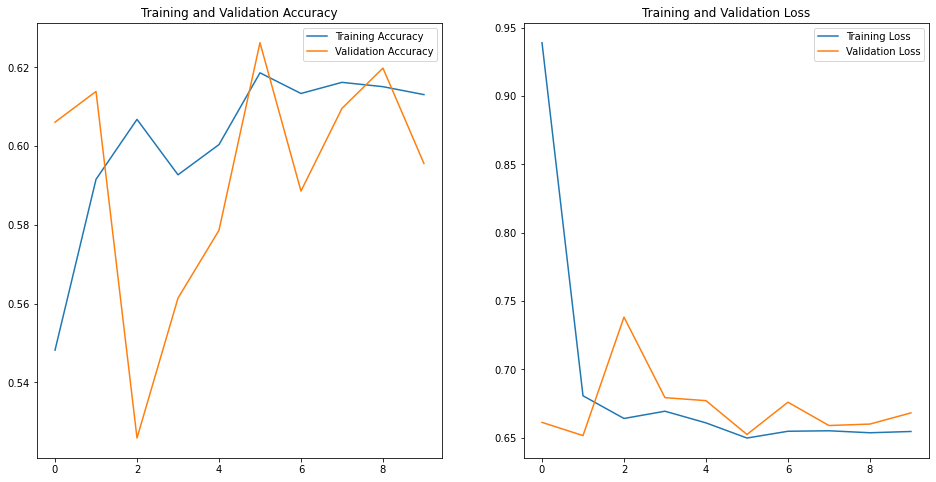

In [225]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## MLP - Model 3

In [83]:
img_height, img_width = 104, 104
batch_size = 32
learning_rate = 1e-5
epochs = 10

In [84]:
model = tf.keras.Sequential([
    
    layers.Flatten(input_shape=(img_height, img_width, 3)),
    
    layers.Dense(42, activation= "relu"),
    layers.Dense(24, activation= "relu"),
    layers.Dense(16, activation= "relu"),
    layers.Dense(16, activation= "relu"),    
    
    layers.Dense(num_classes, activation="softmax")
])

In [85]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [86]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_14 (Flatten)        (None, 32448)             0         
                                                                 
 dense_57 (Dense)            (None, 42)                1362858   
                                                                 
 dense_58 (Dense)            (None, 24)                1032      
                                                                 
 dense_59 (Dense)            (None, 16)                400       
                                                                 
 dense_60 (Dense)            (None, 16)                272       
                                                                 
 dense_61 (Dense)            (None, 2)                 34        
                                                                 
Total params: 1,364,596
Trainable params: 1,364,596
N

In [87]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
503/503 [==============================] - 42s 78ms/step - loss: 1.7056 - accuracy: 0.5164 - val_loss: 0.8911 - val_accuracy: 0.5361
Epoch 2/10
503/503 [==============================] - 40s 79ms/step - loss: 0.8043 - accuracy: 0.5406 - val_loss: 0.7811 - val_accuracy: 0.5561
Epoch 3/10
503/503 [==============================] - 41s 82ms/step - loss: 0.7435 - accuracy: 0.5613 - val_loss: 0.7317 - val_accuracy: 0.5727
Epoch 4/10
503/503 [==============================] - 35s 67ms/step - loss: 0.7229 - accuracy: 0.5769 - val_loss: 0.7178 - val_accuracy: 0.5808
Epoch 5/10
503/503 [==============================] - 34s 67ms/step - loss: 0.7028 - accuracy: 0.5827 - val_loss: 0.7096 - val_accuracy: 0.5743
Epoch 6/10
503/503 [==============================] - 35s 69ms/step - loss: 0.7033 - accuracy: 0.5895 - val_loss: 0.6954 - val_accuracy: 0.5828
Epoch 7/10
503/503 [==============================] - 33s 66ms/step - loss: 0.6854 - accuracy: 0.5985 - val_loss: 0.6811 - val_accuracy:

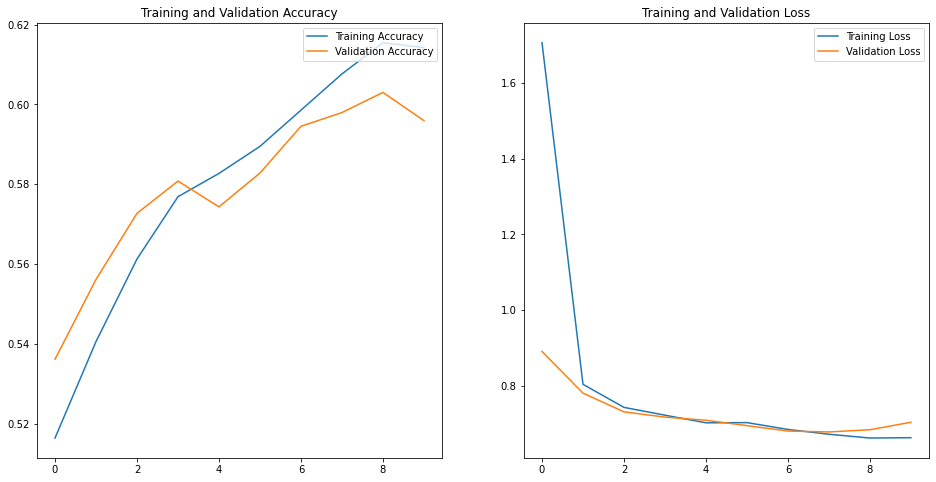

In [88]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Convolutional Neural Networks

## CNN - Model 1

In [27]:
img_height, img_width = 104, 104
batch_size = 32
epochs = 10

In [203]:
model = Sequential([
    
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    layers.Conv2D(16,(3,3), activation = 'relu'), 
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(32,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(num_classes, activation = 'softmax')
])

In [204]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [205]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 98, 98, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 46, 46, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 flatten_31 (Flatten)        (None, 16928)           

In [206]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
403/403 [==============================] - 94s 227ms/step - loss: 0.6399 - accuracy: 0.6433 - val_loss: 0.5754 - val_accuracy: 0.7011
Epoch 2/10
403/403 [==============================] - 73s 179ms/step - loss: 0.5319 - accuracy: 0.7365 - val_loss: 0.5180 - val_accuracy: 0.7488
Epoch 3/10
403/403 [==============================] - 81s 201ms/step - loss: 0.4747 - accuracy: 0.7728 - val_loss: 0.5278 - val_accuracy: 0.7520
Epoch 4/10
403/403 [==============================] - 87s 215ms/step - loss: 0.4348 - accuracy: 0.7964 - val_loss: 0.4763 - val_accuracy: 0.7908
Epoch 5/10
403/403 [==============================] - 79s 196ms/step - loss: 0.4080 - accuracy: 0.8158 - val_loss: 0.4636 - val_accuracy: 0.7896
Epoch 6/10
403/403 [==============================] - 80s 200ms/step - loss: 0.3753 - accuracy: 0.8317 - val_loss: 0.4677 - val_accuracy: 0.7902
Epoch 7/10
403/403 [==============================] - 82s 203ms/step - loss: 0.3401 - accuracy: 0.8500 - val_loss: 0.4743 - val_ac

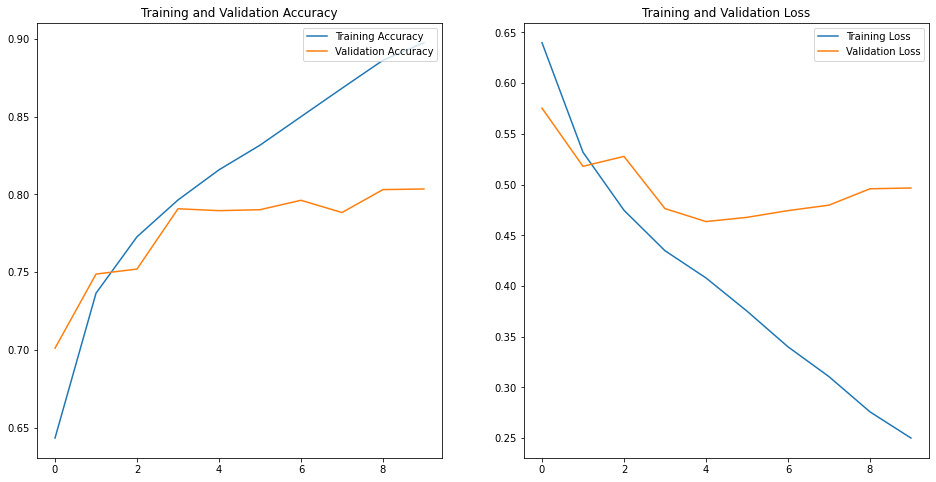

In [207]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## CNN - Model 2

In [28]:
epochs =10

In [29]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    layers.Conv2D(16,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(32,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation = 'softmax')
])

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 104, 104, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 102, 102, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 51, 51, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 49, 49, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 64)        1

In [32]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


/opt/anaconda3/lib/python3.8/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


503/503 [==============================] - 147s 288ms/step - loss: 0.6054 - accuracy: 0.6575 - val_loss: 0.5318 - val_accuracy: 0.7336
Epoch 2/10
503/503 [==============================] - 112s 222ms/step - loss: 0.5021 - accuracy: 0.7533 - val_loss: 0.4743 - val_accuracy: 0.7718
Epoch 3/10
503/503 [==============================] - 111s 221ms/step - loss: 0.4381 - accuracy: 0.7918 - val_loss: 0.4322 - val_accuracy: 0.8005
Epoch 4/10
503/503 [==============================] - 111s 220ms/step - loss: 0.3855 - accuracy: 0.8241 - val_loss: 0.3997 - val_accuracy: 0.8183
Epoch 5/10
503/503 [==============================] - 117s 232ms/step - loss: 0.3343 - accuracy: 0.8516 - val_loss: 0.4148 - val_accuracy: 0.8205
Epoch 6/10
503/503 [==============================] - 110s 218ms/step - loss: 0.2919 - accuracy: 0.8750 - val_loss: 0.3788 - val_accuracy: 0.8306
Epoch 7/10
503/503 [==============================] - 112s 223ms/step - loss: 0.2437 - accuracy: 0.8993 - val_loss: 0.4296 - val_accura

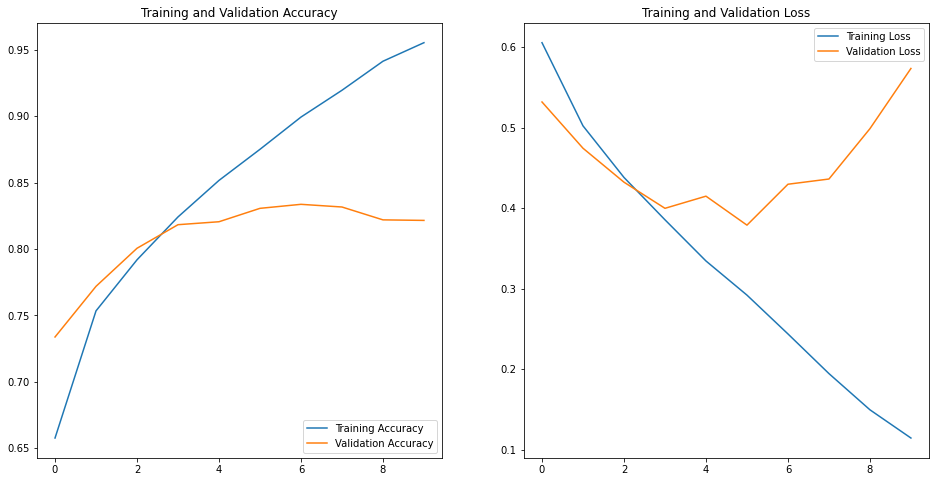

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## CNN - Model 3

In [34]:
img_height, img_width = 104, 104
batch_size = 32
epochs = 5

In [35]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    layers.Conv2D(32,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.1),
    
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.1),
    
    layers.Conv2D(128,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    
    layers.Dense(num_classes, activation = 'softmax')
])

In [36]:
model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [44]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 104, 104, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 102, 102, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 51, 51, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 51, 51, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 49, 49, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                 

In [45]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
503/503 [==============================] - 254s 500ms/step - loss: 0.6270 - accuracy: 0.6329 - val_loss: 0.5531 - val_accuracy: 0.7185
Epoch 2/5
503/503 [==============================] - 236s 469ms/step - loss: 0.5050 - accuracy: 0.7497 - val_loss: 0.4727 - val_accuracy: 0.7779
Epoch 3/5
503/503 [==============================] - 244s 485ms/step - loss: 0.4462 - accuracy: 0.7903 - val_loss: 0.4316 - val_accuracy: 0.8092
Epoch 4/5
503/503 [==============================] - 236s 468ms/step - loss: 0.4040 - accuracy: 0.8140 - val_loss: 0.4410 - val_accuracy: 0.7882
Epoch 5/5
503/503 [==============================] - 223s 442ms/step - loss: 0.3642 - accuracy: 0.8401 - val_loss: 0.3785 - val_accuracy: 0.8346


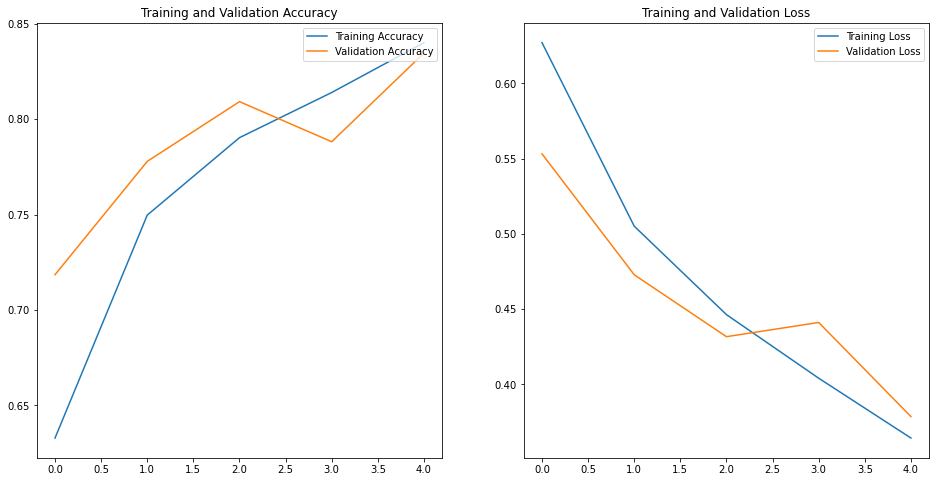

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#  

[ Config for later prediction ]

In [411]:
batch_size = 40

In [412]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

test_ds_pred = configure_for_performance(test_ds) 

# Cross Validation for the risk estimates

###  CV for MLP 

In [413]:
batch_size = 1

In [414]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

test_ds = configure_for_performance(test_ds) 

In [415]:
num_folds = 5
df_length = len(test_ds)
fold_size = df_length // num_folds

In [416]:
epochs = 5

In [48]:
accuracies = [] 
losses = []

for k in range(num_folds):
    
    q = k*fold_size

    train_I = test_ds.take(q)
    val_cv = test_ds.skip(q).take(fold_size)
    train_II = test_ds.skip(q + fold_size)

    train_cv = train_II.concatenate(train_I)
    
    
    model = tf.keras.Sequential([
    
    layers.Flatten(input_shape=(img_height, img_width, 3)),
    
    layers.Dense(42, activation= "relu"),
    layers.Dense(24, activation= "relu"),
    layers.Dense(16, activation= "relu"),
    layers.Dense(16, activation= "relu"),    
    
    layers.Dense(num_classes, activation="softmax")
    ])
    
    
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    history = model.fit(
              train_cv,
              epochs=epochs
            )
    
    scores = model.evaluate(
             val_cv
            )
    
    accuracies.append(scores[1])
    losses.append(scores[0])

Epoch 1/5


/opt/anaconda3/lib/python3.8/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2972/2972 [==============================] - 76s 24ms/step - loss: 48.1272 - accuracy: 0.5162
Epoch 2/5
2972/2972 [==============================] - 70s 24ms/step - loss: 0.7130 - accuracy: 0.5081
Epoch 3/5
2972/2972 [==============================] - 66s 22ms/step - loss: 0.6934 - accuracy: 0.4838
Epoch 4/5
2972/2972 [==============================] - 69s 23ms/step - loss: 0.6935 - accuracy: 0.4983
Epoch 5/5
742/742 [==============================] - 2s 2ms/step - loss: 0.6959 - accuracy: 0.5013
Epoch 1/5
2972/2972 [==============================] - 64s 21ms/step - loss: 46.5051 - accuracy: 0.4997
Epoch 2/5
2972/2972 [==============================] - 60s 20ms/step - loss: 0.7005 - accuracy: 0.4916
Epoch 3/5
2972/2972 [==============================] - 66s 22ms/step - loss: 0.6991 - accuracy: 0.4946
Epoch 4/5
2972/2972 [==============================] - 67s 23ms/step - loss: 0.6930 - accuracy: 0.5091
Epoch 5/5
742/742 [==============================] - 2s 2ms/step - loss: 0.6930 - acc

In [98]:
avg_accuracy = np.mean(accuracies)

In [99]:
zero_one_loss = 1 - avg_accuracy
print(zero_one_loss)

0.49326145052909853


### CV for CNN 

In [65]:
num_folds = 5
df_length = len(test_ds)
fold_size = df_length // num_folds

In [66]:
epochs = 5

In [67]:
accuracies = [] 
losses = []

for k in range(num_folds):
    
    q = k*fold_size

    train_I = test_ds.take(q)
    val_cv = test_ds.skip(q).take(fold_size)
    train_II = test_ds.skip(q + fold_size)

    train_cv = train_II.concatenate(train_I)
    
    
    model = Sequential([
        
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    layers.Conv2D(32,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(128,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    
    layers.Dense(num_classes, activation = 'softmax')
    ])
    
    
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    history = model.fit(
              train_cv,
              epochs=epochs
            )
    
    scores = model.evaluate(
             val_cv
            )
    
    accuracies.append(scores[1])
    losses.append(scores[0])

Epoch 1/5
2972/2972 [==============================] - 59s 19ms/step - loss: 0.7005 - accuracy: 0.5017
Epoch 2/5
2972/2972 [==============================] - 66s 22ms/step - loss: 0.6971 - accuracy: 0.5165
Epoch 3/5
2972/2972 [==============================] - 80s 27ms/step - loss: 0.6864 - accuracy: 0.5542
Epoch 4/5
2972/2972 [==============================] - 67s 22ms/step - loss: 0.6694 - accuracy: 0.5905
Epoch 5/5
742/742 [==============================] - 5s 6ms/step - loss: 0.6250 - accuracy: 0.6725
Epoch 1/5
2972/2972 [==============================] - 61s 20ms/step - loss: 0.6995 - accuracy: 0.5158
Epoch 2/5
2972/2972 [==============================] - 61s 20ms/step - loss: 0.6951 - accuracy: 0.4990
Epoch 3/5
2972/2972 [==============================] - 58s 19ms/step - loss: 0.6932 - accuracy: 0.5098
Epoch 4/5
2972/2972 [==============================] - 57s 19ms/step - loss: 0.7076 - accuracy: 0.5155
Epoch 5/5
742/742 [==============================] - 5s 6ms/step - loss: 0.69

In [68]:
avg_accuracy = np.mean(accuracies)

In [69]:
zero_one_loss = 1 - avg_accuracy
print(zero_one_loss)

0.3897574067115783


# Prediction for CNN

In [417]:
result = model.predict(test_ds)

3714/3714 [==============================] - 30s 8ms/step


In [418]:
y_pred_labels = np.argmax(result, axis=-1)

In [419]:
true_labels = np.concatenate([y for x , y in test_ds], axis=0)

In [421]:
pred_label = ['dog' if p==1 else 'cat' for p in y_pred_labels]

In [422]:
image_batchII, label_batchII = next(iter(test_ds_pred))

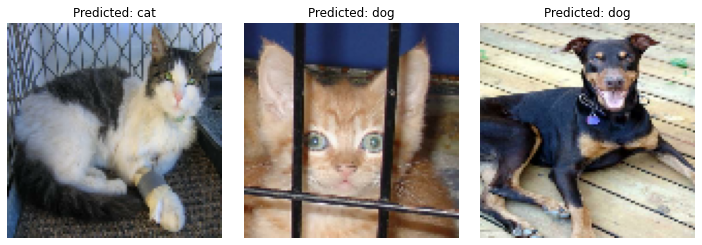

In [435]:
plt.figure(figsize=(10, 10))
for i in range(3,6):
    plt.subplot(3, 3, i+1)
    plt.imshow(image_batchII[i].numpy().astype("uint8"))
    plt.title('Predicted: ' + pred_label[i])
    plt.axis('off')
plt.tight_layout()